In [1]:
import numpy as np
import pandas as pd
import re
import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

data = pd.read_csv('../data/data_keep_50000.csv', low_memory=False)
train_df = pd.read_csv('../data/meinian_round1_train_20180408.csv')
test_df = pd.read_csv('../data/meinian_round1_test_a_20180409.csv')

# 通过 describe 查看特征的类型，标准差，修正类型和异常数据
train_df['收缩压'] = pd.to_numeric(train_df['收缩压'], errors='coerce')
train_df['舒张压'] = pd.to_numeric(train_df['舒张压'], errors='coerce')
train_df.loc[22712, '血清甘油三酯'] = 7.75
train_df['血清甘油三酯'] = pd.to_numeric(train_df['血清甘油三酯'], errors='coerce')
# train_df['舒张压'].sort_values(ascending=False)[:5]
train_df.loc[22357, '舒张压'] = np.nan
train_df.loc[29394, '舒张压'] = np.nan
train_df.loc[29394, '收缩压'] = np.nan
train_df['血清低密度脂蛋白'][train_df['血清低密度脂蛋白']<0] = 0

In [2]:
# 合并数据
merged_train_df = pd.merge(train_df, data, on='vid', sort=False)
merged_test_df = pd.merge(test_df, data, on='vid', sort=False)
combine = [merged_train_df, merged_test_df]

In [3]:
print(merged_train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38199 entries, 0 to 38198
Columns: 262 entries, vid to A601
dtypes: float64(16), object(246)
memory usage: 76.6+ MB
None


In [4]:
# 提取数值特征(大于0.5)
numerical_feature = []

def get_num_prop(data_col):
    num_counts = data_col.astype(
        str).str.match(r'^(-?\d+)(\.\d+)?$').sum()
    na_counts = data_col.isna().sum()
    return num_counts / (data_col.shape[0] - na_counts)

for col in merged_train_df.columns.values:
    if get_num_prop(merged_train_df[col]) > 0.5:
        numerical_feature.append(col)

label = numerical_feature[0:5]        
numerical_feature = numerical_feature[5:]
print('numerical feature count: %s' %len(numerical_feature))
print(numerical_feature)

numerical feature count: 108
['0424', '100005', '100006', '100007', '100014', '10002', '10003', '10004', '1106', '1107', '1115', '1117', '1127', '1321', '1322', '1325', '1326', '1345', '139', '143', '1474', '155', '1814', '1815', '183', '1840', '1845', '1850', '190', '191', '192', '193', '2174', '2333', '2372', '2403', '2404', '2405', '2406', '2420', '269003', '269004', '269005', '269006', '269007', '269008', '269009', '269010', '269011', '269012', '269013', '269014', '269015', '269016', '269017', '269018', '269019', '269020', '269021', '269022', '269023', '269024', '269025', '300017', '300021', '31', '312', '313', '314', '315', '316', '317', '319', '3193', '32', '320', '33', '34', '37', '38', '39', '669001', '669002', '669006', '809001', '809009', '979001', '979002', '979003', '979004', '979005', '979006', '979007', '979008', '979009', '979011', '979012', '979013', '979014', '979015', '979016', '979017', '979018', '979019', '979020', '979021', '979022', '979023']


In [5]:
def search_non_numeric(data):
    if not re.search(r'^(-?\d+)(\.\d+)?$', data) and data!='nan':
        non_numeric.append(data)

# non_numeric = []
# # applymap 会有问题，第一列会操作两次
# for col in numerical_feature:
#     non_numeric.append('----'+col+'----')
#     temp = merged_train_df[col].astype('str').apply(search_non_numeric)
# for col in numerical_feature:
#     non_numeric.append('----'+col+'----')
#     temp = merged_test_df[col].astype('str').apply(search_non_numeric)

In [6]:
# len(non_numeric)

In [7]:
# with open('mix_in_numeric.txt', 'w') as f:
#     for t in non_numeric:
#         f.write(t+'\n')

In [8]:
def print_non_num(feature_series):
    print(feature_series[feature_series.str.match(r'^(-?\d+)(\.\d+)?$')==False])

In [9]:
def convert_mixed_num(data):
    data = data.strip()
    special_cases = ['未见','阴性']
    try:
        ret = float(data)
        return ret if data >=0 else np.nan
    except:
        if data in special_cases:mode
            return 0
        all_match = re.findall(r'\d+\.?\d*', data) # 注意：不带负号
        if all_match:
            all_list = [float(i) for i in all_match]
            return sum(all_list)/len(all_list)    # 取均值
        else:
            return np.nan

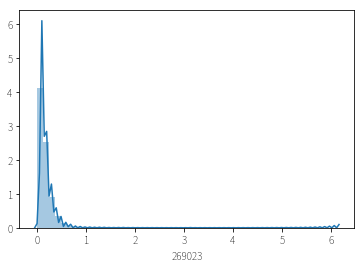

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

test = merged_train_df['269023'].astype(
        'str').apply(convert_mixed_num).dropna()
sns.distplot(test)
plt.show()

In [ ]:
merged_train_df.loc[32230,'1850'] = 3.89
merged_train_df.loc[[2527,3027],'192'] = 16.07, 12.01
merged_train_df.loc[3163,'193'] = np.nan
merged_train_df.loc[6055,'2333'] = 5.0    # 多了小数点
merged_train_df.loc[5085,'269013']    # 未见，映射成0
merged_train_df.loc[[8551,8840,9072,9309],'3193'] = '>=1.030'
merged_test_df.loc[2327, '3193'] = '>=1.030'
merged_test_df.loc[2327, '1840'] = '<=5.0'

In [72]:
merged_train_df.loc[21196,'2405'] = np.nan  # 异常大
merged_train_df.loc[33729,'0424'] = np.nan

In [40]:
# RF 得到的特征重要性
low_importance = ['269024', '979013', '979018', '1325', '979014', '1326']

for df in combine:
    df[numerical_feature] = df[numerical_feature].astype(
    'str').applymap(convert_mixed_num)
    df[numerical_feature] = np.log1p(df[numerical_feature])
    # to_fill = df[numerical_feature].median()
    # df[numerical_feature] = preprocessing.robust_scale(df[numerical_feature].fillna(to_fill))
    df.drop(columns=low_importance, inplace=True)    # 去掉不重要的特征

need_log1p = ['100007', '1117', '1127', '1814', '1815', '183']
for col in need_log1p:
    for df in combine:
        df[col] = np.log1p(df[col])

In [15]:
label_numerical_df = merged_train_df[label + numerical_feature]

In [16]:
# corr = label_numerical_df.corr()
# sns.pairplot(corr)

In [17]:
# plt.show()

In [18]:
merged_train_df.describe()

,收缩压,舒张压,血清甘油三酯,血清高密度脂蛋白,血清低密度脂蛋白,0424,100005,100006,100007,100014,10002,10003,10004,1106,1107,1115,1117,1127,1321,1322,1325,1326,1345,139,143,1474,155,1814,1815,183,1840,1845,1850,190,191,192,193,2174,2333,2372,2403,2404,2405,2406,2420,269003,269004,269005,269006,269007,269008,269009,269010,269011,269012,269013,269014,269015,269016,269017,269018,269019,269020,269021,269022,269023,269024,269025,300017,300021,31,312,313,314,315,316,317,319,3193,32,320,33,34,37,38,39,669001,669002,669006,809001,809009,979001,979002,979003,979004,979005,979006,979007,979008,979009,979011,979012,979013,979014,979015,979016,979017,979018,979019,979020,979021,979022,979023
count,38191.000000,38190.000000,38158.000000,38199.000000,38199.000000,30270.000000,12899.000000,17473.000000,15043.000000,4938.000000,20113.000000,18408.000000,34717.000000,5705.000000,5568.000000,22979.000000,26085.000000,8222.000000,17015.000000,17009.000000,6293.000000,6287.000000,9234.000000,5666.000000,5427.000000,5080.000000,8820.000000,38018.000000,36194.000000,20705.000000,36665.000000,17145.000000,35078.000000,37461.000000,37082.000000,29808.000000,25799.000000,20210.000000,17493.000000,17349.000000,36776.000000,36777.000000,36608.000000,13217.000000,9775.000000,8218.000000,8362.000000,8058.000000,8219.000000,7288.000000,8219.000000,8219.000000,8219.000000,7980.000000,8219.000000,8249.000000,8215.000000,8359.000000,8215.000000,8219.000000,8363.000000,8219.000000,8363.00000,8362.000000,8362.000000,8362.000000,8362.000000,8316.000000,5058.000000,5829.000000,17712.000000,17571.000000,17459.000000,22234.000000,17712.000000,17712.000000,17459.000000,17712.000000,36638.000000,17553.000000,16938.000000,17409.000000,13957.000000,17712.000000,17712.000000,14101.000000,5289.000000,5367.000000,5160.000000,5649.000000,4858.000000,6832.000000,6704.000000,6869.000000,6870.000000,6286.000000,6615.000000,6870.000000,6870.000000,6870.000000,6870.000000,6905.000000,6767.000000,6767.000000,6870.000000,6871.000000,6870.000000,6766.000000,6766.000000,6870.000000,6871.000000,6870.000000,6870.000000
mean,126.052918,77.023619,1.612536,1.406683,2.769756,72.888128,18.969464,14.448569,0.687269,15.415094,9.183797,28.616702,4.787489,1.450423,0.957126,75.152059,34.423413,118.552245,0.817170,0.826037,0.916013,0.919260,173.631159,1.592666,13.674605,93.227131,2.272346,28.540822,23.668469,75.250600,6.114276,1.664133,5.278316,70.512614,333.618480,13.249230,4.064471,46.600614,1.724999,3.318521,68.275377,165.120286,24.342537,58.049584,78.198271,15.227035,9.235608,0.196681,214.206473,46.271937,340.019601,30.710196,90.245711,42.113750,145.770288,4.739366,3.714734,0.397310,1.802418,60.325677,6.579583,30.182888,6.09749,2.694310,0.233265,0.165098,0.012579,13.340669,1.100812,10.139740,4.736107,6.257604,143.232866,38.991491,90.603513,30.289683,334.513494,215.117475,1.019033,3.768755,9.410126,2.076115,0.426795,57.697587,30.840653,7.730919,3.513815,1.484888,7.259435,6.435024,1.620080,15.403295,0.192409,9.230496,214.194367,12.153151,39.875247,325.288295,30.151803,91.503314,142.016303,4.766898,0.032273,0.154203,3.520148,0.354890,2.060746,0.547857,2.497774,56.981725,5.831713,34.172217,6.120060
std,19.265082,13.385752,1.335518,0.341184,0.852075,9.084214,12.073726,2.659313,4.187223,5.406276,4.083286,4.205664,9.768690,0.260296,0.247000,24.124697,41.350377,156.293794,0.375756,0.374986,0.276034,0.271517,32.366895,0.541051,7.735491,31.729177,2.853174,25.615856,14.002039,4.850341,0.693084,0.289807,1.335770,18.377908,94.177682,5.520909,2.299311,3.148518,2.616296,5.314787,297.903978,8.684456,3.579534,7.946809,11.335366,3.243515,1.476703,0.130491,55.690242,4.622187,15.234826,2.594303,6.180244,7.322649,17.252298,0.585971,1.277855,0.149939,0.610732,8.814129,1.976209,8.304851,1.61659,2.199148,0.334817,0.161030,0.021401,1.652563,1.385793,8.359404,0.523044,1.620847,16.772720,13.188444,6.050279,2.471872,15.049161,55.691769,0.039605,1.258986,1.791910,0.737653,0.209125,13.335674,10.749796,6.360497,3.364076,1.251068,6.600688,3.904337,0.8

In [119]:
merged_train_df['2174'].dropna().sort_values().head()

1743     15.00
23506    33.20
14884    33.73
21640    34.40
32525    34.60
Name: 2174, dtype: float64

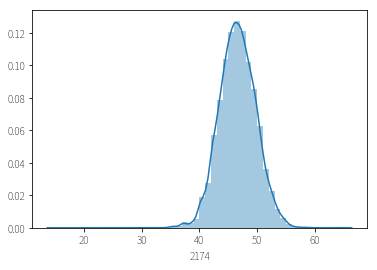

In [118]:
# test = merged_train_df['100007'].dropna()
test = merged_train_df['2174']
sns.distplot(test.dropna())
plt.show()

In [20]:
# %matplotlib inline
# fig = plt.gcf()
# fig.set_size_inches(18, 18)
# sns.heatmap(merged_train_df[label+numerical_feature].corr())
# plt.show()

In [23]:
merged_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38199 entries, 0 to 38198
Columns: 256 entries, vid to A601
dtypes: float64(107), object(149)
memory usage: 76.1+ MB


In [28]:
numerical_feature = [i for i in numerical_feature if i not in low_importance]

In [30]:
merged_train_df[numerical_feature].head()

,0424,100005,100006,100007,100014,10002,10003,10004,1106,1107,1115,1117,1127,1321,1322,1345,139,143,1474,155,1814,1815,183,1840,1845,1850,190,191,192,193,2174,2333,2372,2403,2404,2405,2406,2420,269003,269004,269005,269006,269007,269008,269009,269010,269011,269012,269013,269014,269015,269016,269017,269018,269019,269020,269021,269022,269023,269025,300017,300021,31,312,313,314,315,316,317,319,3193,32,320,33,34,37,38,39,669001,669002,669006,809001,809009,979001,979002,979003,979004,979005,979006,979007,979008,979009,979011,979012,979015,979016,979017,979019,979020,979021,979022,979023
0,74.0,12.9,NaN,0.26,NaN,6.3,29.1,2.94,1.09,1.03,72.0,23.0,NaN,1.0,0.8,NaN,NaN,NaN,NaN,NaN,32.0,32.0,81.5,6.5,1.62,4.46,55.0,215.0,8.5,2.2,50.4,0.86,2.60,72.9,166.5,26.3,NaN,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.82,6.3,136.0,41.1,85.4,28.2,330.0,255.0,1.015,4.1,10.5,2.0,0.2,65.6,31.8,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,80.0,13.0,NaN,0.16,NaN,12.4,27.2,5.00,1.69,1.42,102.0,162.0,58.0,0.8,0.6,204.0,NaN,15.78,NaN,NaN,189.0,58.0,74.4,6.0,1.74,14.55,71.0,376.0,17.7,5.3,47.2,3.25,1.54,103.4,181.0,31.6,NaN,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.10,8.1,188.0,64.0,90.2,26.4,293.0,158.0,1.025,4.7,10.2,2.7,0.7,58.0,33.4,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,81.0,NaN,13.8,0.26,NaN,11.0,24.9,5.30,NaN,NaN,69.0,115.0,98.0,NaN,NaN,206.0,NaN,8.10,NaN,NaN,281.0,76.0,73.3,5.5,1.94,5.20,78.0,436.0,16.7,5.7,48.4,0.62,5.05,73.6,173.0,24.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.71,4.9,176.0,50.6,88.6,30.8,348.0,168.0,1.030,2.8,9.7,1.7,0.4,58.6,34.0,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,13.4,0.26,NaN,16.8,23.2,4.94,NaN,NaN,60.0,21.0,139.0,NaN,NaN,202.0,NaN,9.90,NaN,3.11,26.0,25.0,73.2,6.0,2.16,4.73,65.9,205.0,22.4,5.6,50.0,0.91,2.96,50.2,161.0,19.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.13,4.0,137.0,38.4,93.0,33.2,354.0,152.0,1.020,1.9,10.0,2.0,0.1,45.4,51.0,3.6,NaN,NaN,NaN,4.46,1.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,11.9,0.20,NaN,NaN,NaN,4.00,NaN,NaN,47.0,15.0,92.0,NaN,NaN,186.0,NaN,5.80,NaN,NaN,24.0,17.0,NaN,7.0,NaN,4.50,46.0,236.0,NaN,NaN,NaN,0.45,3.57,52.0,158.0,20.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.87,4.1,144.0,45.0,92.6,29.6,319.0,225.0,1.015,2.1,9.2,1.7,0.3,50.2,41.4,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
abnormal_num = []
for col in numerical_feature:
    if merged_train_df[col].max() > 1000:
        abnormal_num.append(col)
print(abnormal_num)

['1117', '1127', '1814', '1815', '2403']


In [123]:
merged_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38199 entries, 0 to 38198
Columns: 256 entries, vid to A601
dtypes: float64(107), object(149)
memory usage: 76.1+ MB


In [121]:
merged_train_df.describe(include='O')

,vid,0101,0102,0113,0114,0115,0116,0117,0118,0119,0120,0121,0122,0123,0124,0201,0202,0203,0206,0207,0208,0209,0210,0212,0215,0216,0217,0222,0225,0403,0405,0406,0407,0409,0413,0414,0420,0421,0422,0423,0425,0426,0427,0428,0429,0430,0431,0432,0433,0434,0435,0436,0440,0501,0503,0509,0516,0537,0539,0541,0702,0703,0705,0706,0707,0709,0715,0726,0728,0730,0731,0901,0911,0912,0929,0947,0949,0954,0972,0973,0974,0975,0976,0977,0978,0979,0980,0981,0982,0983,0984,0985,0987,100010,1001,1102,1103,1104,1301,1302,1303,1304,1305,1308,1313,1314,1315,1316,1328,1329,1330,1402,2228,2229,2230,2231,2233,2302,2501,300005,300018,300019,300036,30007,3189,3190,3191,3192,3194,3195,3196,3197,3207,3301,3399,3400,3429,3430,3485,3486,360,3601,3730,4001,A201,A202,A301,A302,A601
count,38199,32509,37643,37311,37304,33977,37222,36589,36588,20904,18877,12978,12978,12978,14132,21674,21959,21932,18884,21011,21200,20113,20842,20770,20150,20532,21953,21979,7610,13885,24659,25308,27517,32056,29071,5411,30568,31728,9400,27036,17950,31868,8956,5785,13799,30515,30261,25883,25802,31518,26710,6751,7495,12378,12379,12370,12138,12074,12380,12074,14983,14978,14939,14980,15023,15112,14179,13935,12819,14173,14645,26755,28425,28173,26075,28417,28388,28438,14210,19971,25104,25047,24901,15755,23770,22850,21706,7294,7229,7440,7161,25157,5446,27116,37092,17772,16973,2062,24637,24458,22627,23016,20911,26625,18736,19009,19851,14903,16814,11392,5841,7716,11209,10712,10603,10603,10580,37483,10529,34183,5592,5773,11443,10608,9978,36549,36669,36669,8388,36669,36596,36669,24729,8751,23264,22797,33527,36669,10458,10795,7889,14794,33489,8426,22690,22817,5028,5052,9180
unique,38199,19667,31701,6031,4216,100,464,3362,3064,229,5571,5613,584,624,51,63,79,190,11,18,90,180,93,11,157,27,111,2979,169,9,40,23,14,2503,102,3,14,63,4,34,28,93,9,3,15,8,9,7,8,1916,66,52,20,80,580,1626,459,63,5403,66,312,789,205,131,37,5547,116,21,4,244,845,45,101,236,272,121,179,5076,125,26,41,151,10,3,871,4,3,10,5,46,31,97,248,31,2969,2413,4858,113,128,323,38,14,65,8633,27,216,30,407,31,115,548,936,112,174,74,194,208,30,916,258,635,484,1548,28,16,19,13,16,12,17,21,5,21,1856,10,10,298,24,24,17,18,410,34,165,7452,4597,1924,1114,66
top,762bb7fd22ce9b71656e326a0d4b00a8,双侧甲状腺大小形态正常，包膜光整，实质回声均匀，未见明显异常回声。CDFI：血流显示未见异常。,肝、胆、胰、脾、左肾、右肾未发现明显异常,肝脏大小、形态正常，包膜光整，肝内血管走行较清晰，回声均匀。,胆囊大小、形态正常，囊壁光整，囊腔内透声好，胆总管无扩张。,胰腺大小、形态正常，边缘规整，内部回声均匀，胰管未见扩张。,脾脏大小、形态正常，包膜光整，回声均匀。,左肾大小、形态正常，包膜光滑，肾实质回声均匀，集合系统未见明显分离。,右肾大小、形态正常，包膜光滑，肾实质回声均匀，集合系统未见明显分离。,膀胱充盈良好，壁光滑，延续性好，其内透声性良好，未见明显占位性病变。,前列腺大小、形态正常，包膜光滑完整，两侧对称，内部回声均匀。,子宫大小形态正常，宫壁回声均匀，内膜线居中。,左附件区未见明显异常回声。,右附件区未见明显异常回声。,输尿管上段、膀胱壁间段无扩张。,正常,正常,正常,正常,正常,正常,正常,正常,无,正常,正常,正常,耳鼻喉检查未见异常,未见异常,未见异常,未见异常,未见异常,未见异常,内科检查未发现明显异常,未见异常,未见异常,未见异常,整齐,未见异常,未见异常,正常,未见异常,未见异常,未见异常,未见异常,未见异常,未见异常,未见异常,未见异常,无,未见异常,无,未见异常,未见异常,通畅、分泌物少,光滑、大小正常,前位、大小正常、质软,未见异常,妇科检查未发现明显异常,未见异常,无,无,未见明显异常,未见明显异常,未见明显异常,口腔检查未发现明显异常,无,未见明显异常,未见明显异常,无,未见明显异常,未见异常,未见异常,未见异常,未见异常,未见异常，活动自如,未见异常，活动自如,外科检查未发现明显异常,未见异常,无,无,无,无,无,无,无,无,未见异常,未见异常,未见异常,未见异常,无,无,-,正常心电图,心、肺、膈未见明显异常,两侧胸廓对称，气管居中，两肺野显示清晰。两肺门未见增大，主动脉弓及心影大小形态未见异常，两横...,nan;nan,正常,正常,正常,正常,正常,眼科检查（含裂隙灯）未发现明显异常,正常,正常,正常,正常,正常,无,眼底检查未发现明显异常,所检颅内动脉血流速度未见明显异常,阴性,阴性,阴性,阴性,阴性,健康,未见上皮内病变或恶性细胞,未见,阴性,阴性,-,Ⅱ,-,-,-,-,-,-,-,-,未见,HP阴性(dpm=0),黄色,透明,未见,-,阴性,阴性,-,骨量正常,未见,血管弹性度正常，血管腔未见狭窄,胸廓对称，双肺纹理清晰，走行自然，未见异常实变影，双肺门不大。纵隔窗示纵隔无偏移，心影及大血...,详见纸质报告,双侧大脑半球对称，大脑灰白质形态、位置、信号未见异常。脑干、小脑实质未见明显异常信号，FLA...,详见纸质报告,详见纸质报告
freq,1,2859,196,7224,20584,23397,15268,21482,21605,16066,6694,3048,8500,8588,13375,14250,14481,14159,10281,13049,12597,11567,12468,16295,7701,12748,14251,5600,2872,9625,23184,19894,22548,14926,27386,3255,23395,29395,6892,22784,10742,24755,6917,5570,12753,27558,23318,20909,20035,19002,24527,4363,6041,10679,5602,2505,1947,9803,1406,9734,12503,10422,7504,12113,13561,1613,13572,13405,11296,12230,10723,25167,25641,23827,20086,24933,25260,7055,4290,18663,24932,21920,24875,15753,19943,22847,21704,5424,5631,5703,3820,20227,4612,23651,8787,1210,2870,1671,14113,13010,13843,13613,10703,689,10390,9267,10263,7432,11649,3493,1543,930,924